# <center>Avocado Price Forecasting</center>

### Aim :
- To predict / forecast the average price of Avocado based on time series data.
- It is a typical **Time Series Analysis** problem.

### <center>Dataset Attributes</center>
    
- **Date** :The date of the observation
- **AveragePrice** : the average price of a single avocado
- **Total Volume** : Total number of avocados sold
- **4046** : Total number of avocados with PLU 4046 sold
- **4225** : Total number of avocados with PLU 4225 sold
- **4770** : Total number of avocados with PLU 4770 sold
- **Total Bags** : Total number of bags 
- **Small Bags** : Total number of small bags 
- **Large Bags** : Total number of large bags
- **XLarge Bags** : Extra Large Bags
- **type** : conventional or organic
- **year** : year of the date
- **region** : the city or region of the observation

### Notebook Contents :
- Dataset Information
- Exploratory Data Analysis (EDA)
- Summary of EDA
- Time Series Analysis
- Modeling
- Conclusion

### What you will learn :
- Statistical Tests for Time Series Analysis.
- Order selection for ARIMA & SARIMA models.
- In-sample and Out-of-sample forecasting using rolling and non-rolling methods.
- Difference between forecast function and predict function of ARIMA & SARIMA.

### Related Topic Notebooks :
- [Air Passenger Forecasting](https://www.kaggle.com/code/tanmay111999/air-passengers-forecast-arima-sarima) **: Time Series Analysis of Air Passenger travelling using monthly data**

### Lets get started!

# <center>Dataset Information</center>

### Import the Necessary Libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format
import openpyxl

In [2]:
data = pd.read_csv('C:/Users/Peter/DataspellProjects/kaggle/timeseries/data/avocado.csv')
data = data.drop('Unnamed: 0',axis = 1)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


### Data Info :

In [3]:
data.to_excel(r'C:/Users/Peter/DataspellProjects/kaggle/timeseries/data/mydata.xlsx')


In [9]:
data.shape

(18249, 13)

In [10]:
data.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


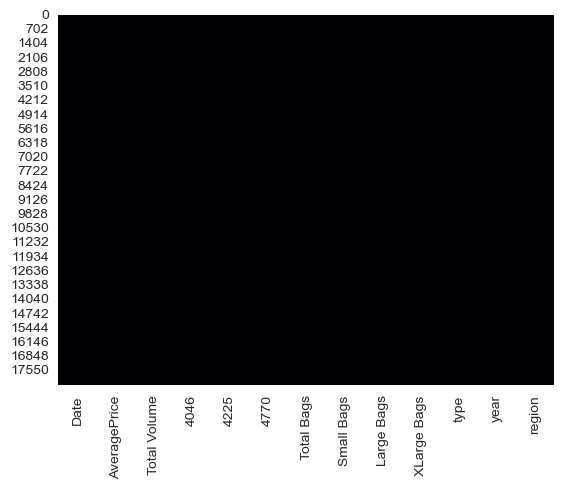

In [12]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

- **No null values** present in the data!

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AveragePrice,18249.00,1.41,0.40,0.44,1.10,1.37,1.66,3.25
Total Volume,18249.00,850644.01,3453545.36,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.00,293008.42,1264989.08,0.00,854.07,8645.30,111020.20,22743616.17
4225,18249.00,295154.57,1204120.40,0.00,3008.78,29061.02,150206.86,20470572.61
4770,18249.00,22839.74,107464.07,0.00,0.00,184.99,6243.42,2546439.11
Total Bags,18249.00,239639.20,986242.40,0.00,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.00,182194.69,746178.51,0.00,2849.42,26362.82,83337.67,13384586.80
Large Bags,18249.00,54338.09,243965.96,0.00,127.47,2647.71,22029.25,5719096.61
XLarge Bags,18249.00,3106.43,17692.89,0.00,0.00,0.00,132.50,551693.65
year,18249.00,2016.15,0.94,2015.00,2015.00,2016.00,2017.00,2018.00


In [14]:
df1 = data.copy(deep = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-11,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-18,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-25,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-02-01,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...


- I will repeat and explain about these steps in detail below. Till then, we will just use this for visualization if required.

# <center>Exploratory Data Analysis</center>

### Target Variable Visualization (AveragePrice) : 

C:\Users\Peter\AppData\Local\Temp\ipykernel_13068\3433337490.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['AveragePrice']);
C:\Users\Peter\AppData\Local\Temp\ipykernel_13068\3433337490.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['AveragePrice']);
C:\Users\Peter\AppData\Lo

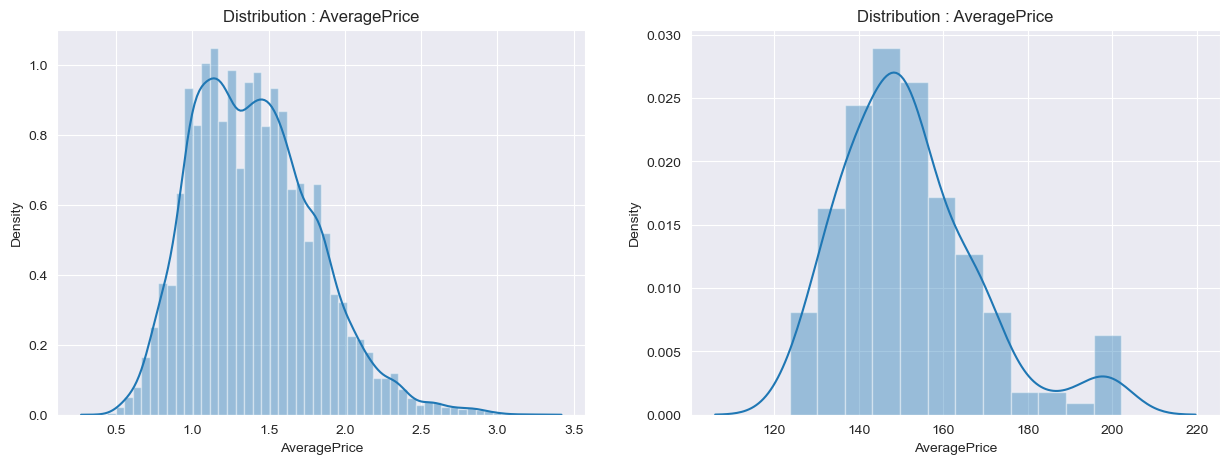

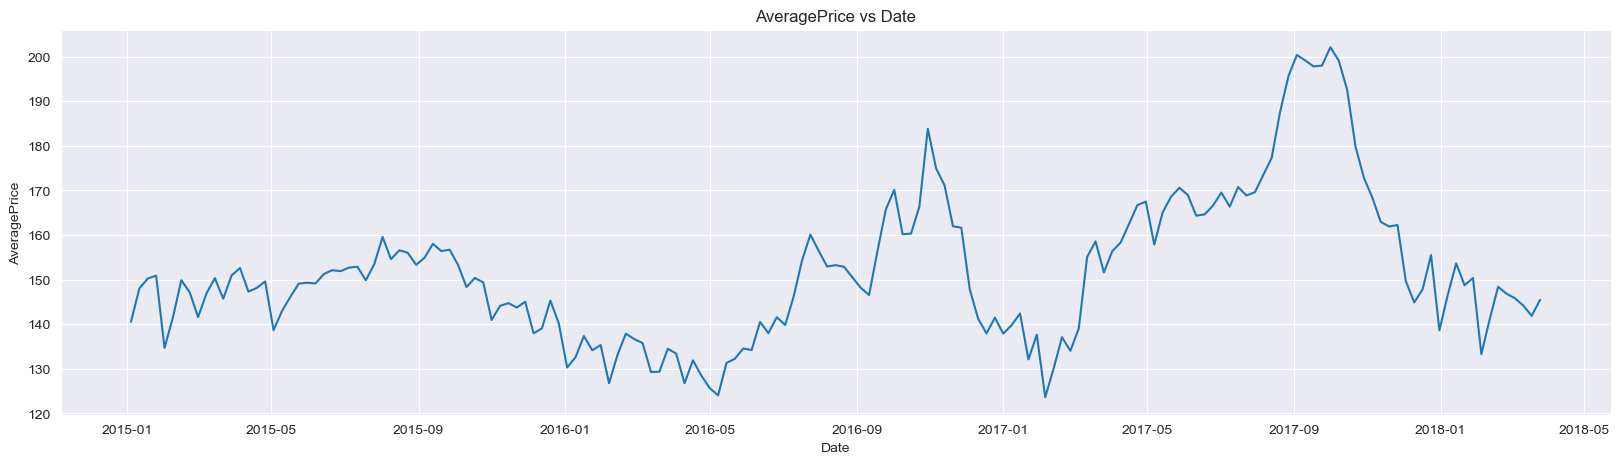

In [15]:
color1 = ['#296C92','#3EB489']
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
sns.distplot(data['AveragePrice']);
plt.title('Distribution : AveragePrice')

plt.subplot(1,2,2)
sns.distplot(df1['AveragePrice']);
plt.title('Distribution : AveragePrice')

fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df1.index ,y = 'AveragePrice',data = df1,palette = color1);
plt.title('AveragePrice vs Date')

plt.show()
fig.tight_layout(pad = 2)

- Distribution of **AveragePrice** that is not resampled is pretty much a **normally distributed** curve. It highlights small double peaks but we will allow it in this case.
- Distribution of **AveragePrice** of the resampled data displays a much better **normally distribution** curve.
- We can clearly observe a positive trend in **AveragePrice** w.r.t **Date**. Repetitive 3 peaks at consistent intervals of time can be observed.
- **AveragePrice** drops around the months of December / January and rises to it's highest value for the months September - November.

### Dividing features into Numerical and Categorical :

In [16]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

numerical_features.remove('Date')
numerical_features.remove('AveragePrice')
numerical_features.remove('region')
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : type year
Numerical Features : Total Volume 4046 4225 4770 Total Bags Small Bags Large Bags XLarge Bags


- We remove the **Date** from the list of numerical_features as it's datatype is supposed to be datetime.
- **AveragePrice** and **region** are removed as we will visualize them separately from the numerical features. 

### Categorical Features :

#### Distribution of Categorical Features :

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['type'] = le.fit_transform(data['type'])

C:\Users\Peter\AppData\Local\Temp\ipykernel_13068\3947223009.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[categorical_features[i]],kde_kws = {'bw' : 1});
C:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2496: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Peter\AppData\Local\Temp\ipykernel_13068\3947223009.py:5: UserWarning: 

`distplot` is a deprecated f

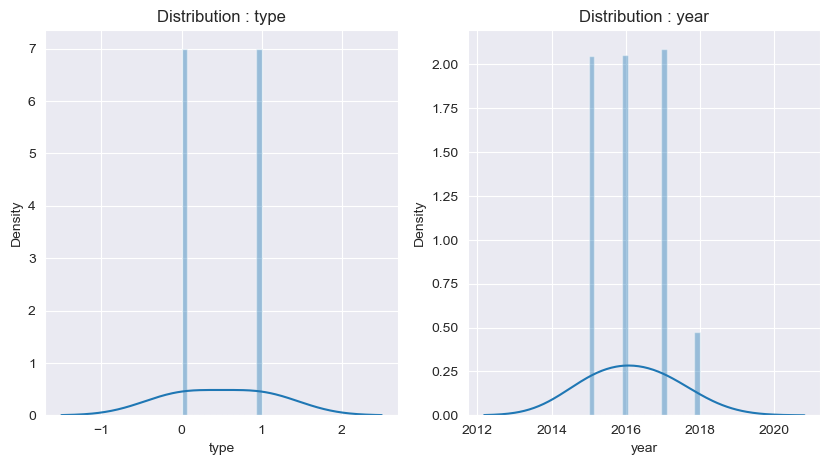

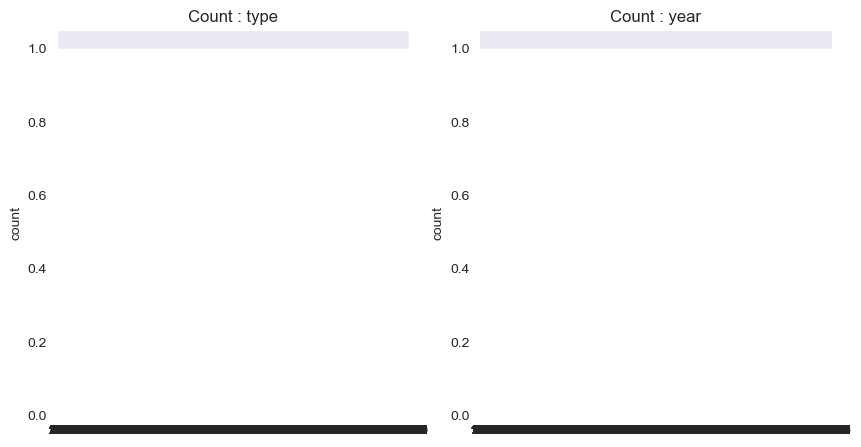

In [18]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))
for i in range(len(categorical_features)):
    
    plt.subplot(1,2,i+1)
    sns.distplot(data[categorical_features[i]],kde_kws = {'bw' : 1});
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)
    
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))
for i in range(len(categorical_features)):
    
    plt.subplot(1,2,i+1)
    sns.countplot(data[categorical_features[i]],palette = color1);
    title = 'Count : ' + categorical_features[i]
    plt.title(title)

- Both the features are **Normally Distributed**.
- Conventional and Organic **type of Avocados** are present in equal numbers.
- Similarly, data points are pretty much same for **year** values 2015, 2016, 2017 and it is followed by a very sharp drop in 2018 probably because of no further data in 2018.

### Categorical Features vs Target Variable (AveragePrice) :

NameError: name 'categorical_features' is not defined

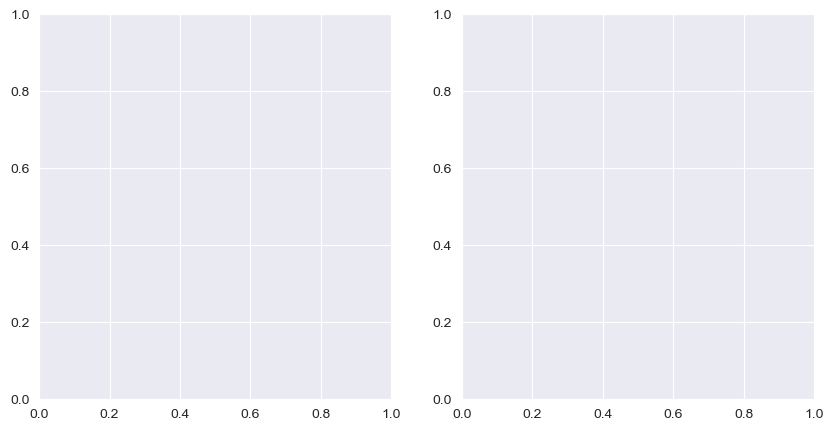

In [4]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))
for i in range(len(categorical_features)):
    
    plt.subplot(1,2,i+1)
    sns.barplot(x = categorical_features[i],y = 'AveragePrice',data = data,palette = color1,edgecolor = 'black')
    title = categorical_features[i] + ' vs AveragePrice'
    plt.title(title);

- **AveragePrice** of Conventional(0) avocados is less than those of Organic(1).
- **AveragePrice** of Avocados is near about the same for the **years** 2015, 2016 and 2018. A rise in **AveragePrice** can be clearly seen for the year 2017.

### Numerical Features :

#### Distribution of Numerical Features :

NameError: name 'numerical_features' is not defined

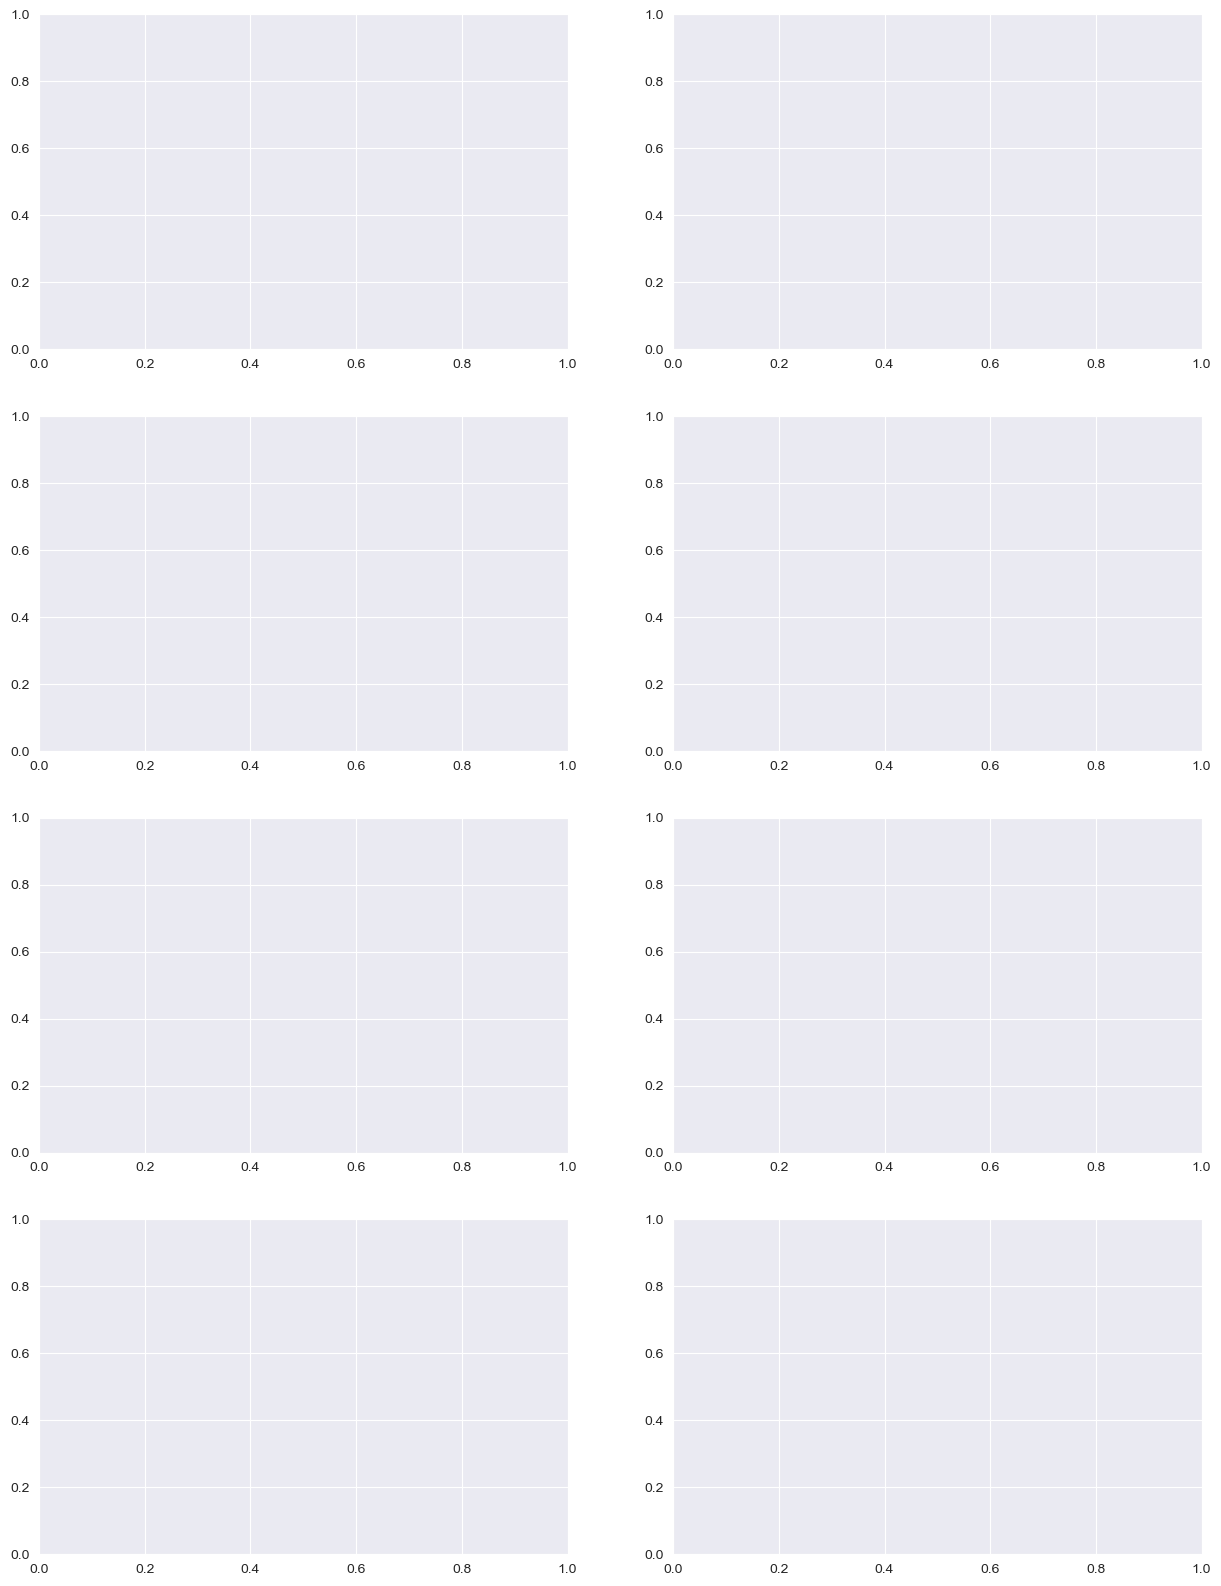

In [5]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (15,20))
for i in range(len(numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(df1[numerical_features[i]])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()
fig.tight_layout(h_pad = 10,w_pad = 5)

- Distributions of the non-resampled data were understandable, hence we visulize the distributions of resampled data.
- **Total Volume**, **4046** & **4225** kind of display a **normally distributed** curve. Remaining numerical features display either a **Double Peak Distribution** or **Right / Positive Skewed Distribution**.

### Numerical Features vs Categorical Features :

#### Numerical Features vs type :

In [ ]:
total_volume = [sum(data[data['type'] == 0]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['type'] == 1]['Total Volume']) / sum(data['Total Volume']) * 100]

avocado_4046 = [sum(data[data['type'] == 0]['4046']) / sum(data['4046']) * 100,
                sum(data[data['type'] == 1]['4046']) / sum(data['4046']) * 100]

avocado_4225 = [sum(data[data['type'] == 0]['4225']) / sum(data['4225']) * 100,
                sum(data[data['type'] == 1]['4225']) / sum(data['4225']) * 100]

avocado_4770 = [sum(data[data['type'] == 0]['4770']) / sum(data['4770']) * 100,
                sum(data[data['type'] == 1]['4770']) / sum(data['4770']) * 100]

total_bags = [sum(data[data['type'] == 0]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['type'] == 1]['Total Bags']) / sum(data['Total Bags']) * 100]

small_bags = [sum(data[data['type'] == 0]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['type'] == 1]['Small Bags']) / sum(data['Small Bags']) * 100]

large_bags = [sum(data[data['type'] == 0]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['type'] == 1]['Large Bags']) / sum(data['Large Bags']) * 100]

xlarge_bags = [sum(data[data['type'] == 0]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['type'] == 1]['XLarge Bags']) / sum(data['XLarge Bags']) * 100]

type_numerical_features_percentage = [total_volume,avocado_4046,avocado_4225,avocado_4770,
                          total_bags,small_bags,large_bags,xlarge_bags]

NameError: name 'numerical_features' is not defined

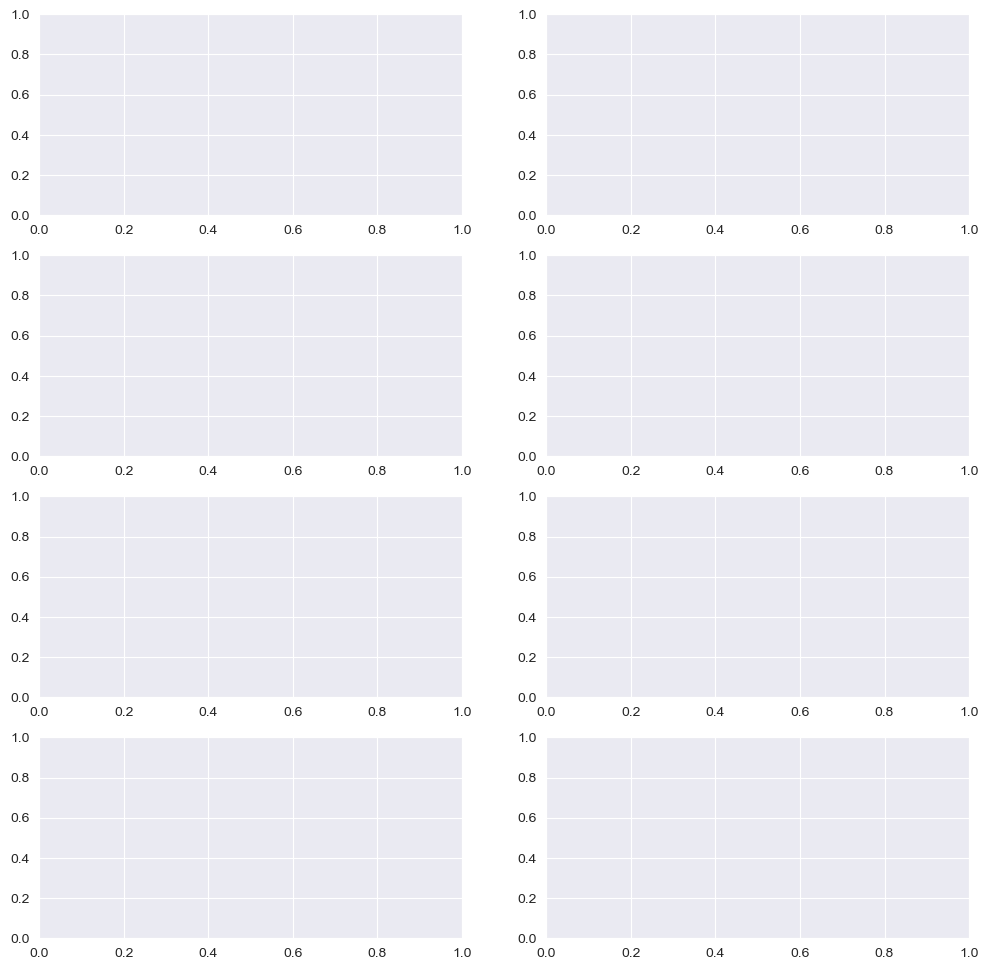

In [6]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (12,12))

for i in range(len(numerical_features)):
    plt.subplot(4,2,i + 1)
    plt.pie(type_numerical_features_percentage[i],labels = ['Conventional (0)','Organic (1)'],autopct = '%1.1f%%',
            startangle = 90, explode = (0,0.1), colors = color1, 
            wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
    title = numerical_features[i]
    plt.title(title);
        
fig.tight_layout(pad = 1)

- Use of **Conventional** avocados dominates the use of **Organic** avocados by a huge margin for all the features.

#### Numerical Features vs year :

In [23]:
total_volume = [sum(data[data['year'] == 2015]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['year'] == 2016]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['year'] == 2017]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['year'] == 2018]['Total Volume']) / sum(data['Total Volume']) * 100]

avocado_4046 = [sum(data[data['year'] == 2015]['4046']) / sum(data['4046']) * 100,
                sum(data[data['year'] == 2016]['4046']) / sum(data['4046']) * 100,
                sum(data[data['year'] == 2017]['4046']) / sum(data['4046']) * 100,
                sum(data[data['year'] == 2018]['4046']) / sum(data['4046']) * 100]

avocado_4225 = [sum(data[data['year'] == 2015]['4225']) / sum(data['4225']) * 100,
                sum(data[data['year'] == 2016]['4225']) / sum(data['4225']) * 100,
                sum(data[data['year'] == 2017]['4225']) / sum(data['4225']) * 100,
                sum(data[data['year'] == 2018]['4225']) / sum(data['4225']) * 100]

avocado_4770 = [sum(data[data['year'] == 2015]['4770']) / sum(data['4770']) * 100,
                sum(data[data['year'] == 2016]['4770']) / sum(data['4770']) * 100,
                sum(data[data['year'] == 2017]['4770']) / sum(data['4770']) * 100,
                sum(data[data['year'] == 2018]['4770']) / sum(data['4770']) * 100]

total_bags = [sum(data[data['year'] == 2015]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['year'] == 2016]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['year'] == 2017]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['year'] == 2018]['Total Bags']) / sum(data['Total Bags']) * 100]

small_bags = [sum(data[data['year'] == 2015]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['year'] == 2016]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['year'] == 2017]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['year'] == 2018]['Small Bags']) / sum(data['Small Bags']) * 100]

large_bags = [sum(data[data['year'] == 2015]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['year'] == 2016]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['year'] == 2017]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['year'] == 2018]['Large Bags']) / sum(data['Large Bags']) * 100]

xlarge_bags = [sum(data[data['year'] == 2015]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['year'] == 2016]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['year'] == 2017]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['year'] == 2018]['XLarge Bags']) / sum(data['XLarge Bags']) * 100]

year_numerical_features_percentage = [total_volume,avocado_4046,avocado_4225,avocado_4770,
                                      total_bags,small_bags,large_bags,xlarge_bags]

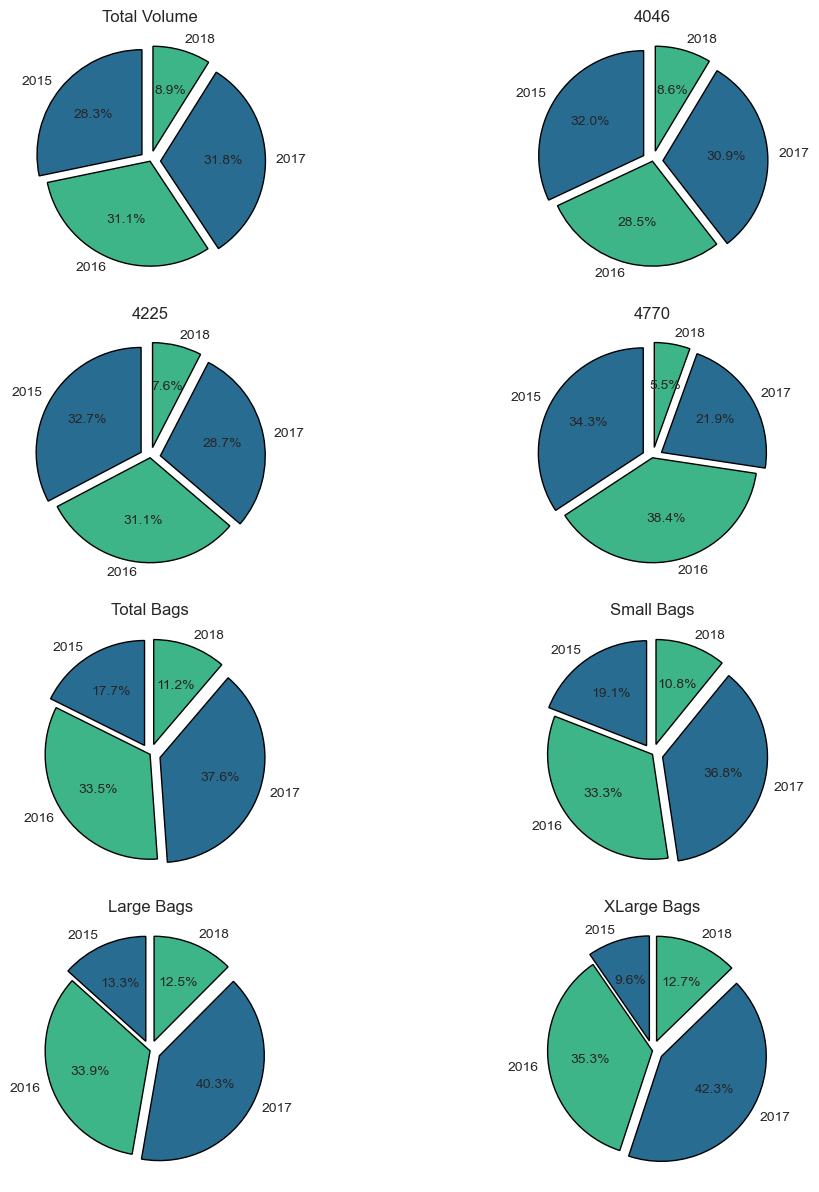

In [24]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (12,12))

for i in range(len(numerical_features)):
    plt.subplot(4,2,i + 1)
    plt.pie(year_numerical_features_percentage[i],labels = ['2015','2016','2017','2018'],autopct = '%1.1f%%',
            startangle = 90, explode = (0.1,0,0.1,0.1), colors = color1, 
            wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
    title = numerical_features[i] 
    plt.title(title);
fig.tight_layout(pad = 1)

- **Total Volume** of avocados has increased year on year starting from 2015. Values for the year 2018 are low because the data recorded is of the 1st 3 months of 2018.
- In 2015, all the 3 types of avocados, **4046**, **4225**, **4770**, are consumed in near about equal amounts. However, in 2016, a clear preference towards **4770** type avocado can be seen with 38.4% people opting for it which is followed by **4225** and **4046** respectively. 
- This order preference of avocado type is completely flipped in 2017 where **4046** is the most preferred avocado with 30.9% and **4770**'s preference has observed a significant drop to 21.9%. **4225** also experienced drop in its preference by 1.33% on average over the 3 years.
- For **bags**, a rising growth in its usage can be seen from 2015. A concrete growth in the usage of **bags** can be observed from 2015 - 2016 by an average margin of **19.07**.

### Numerical Features vs Date :

- Initially, we will look for the bigger picture of the features : **AveragePrice**, **Total Volume**, **Total Bags**. Then we will proceed to visualize the features derived from the above features.

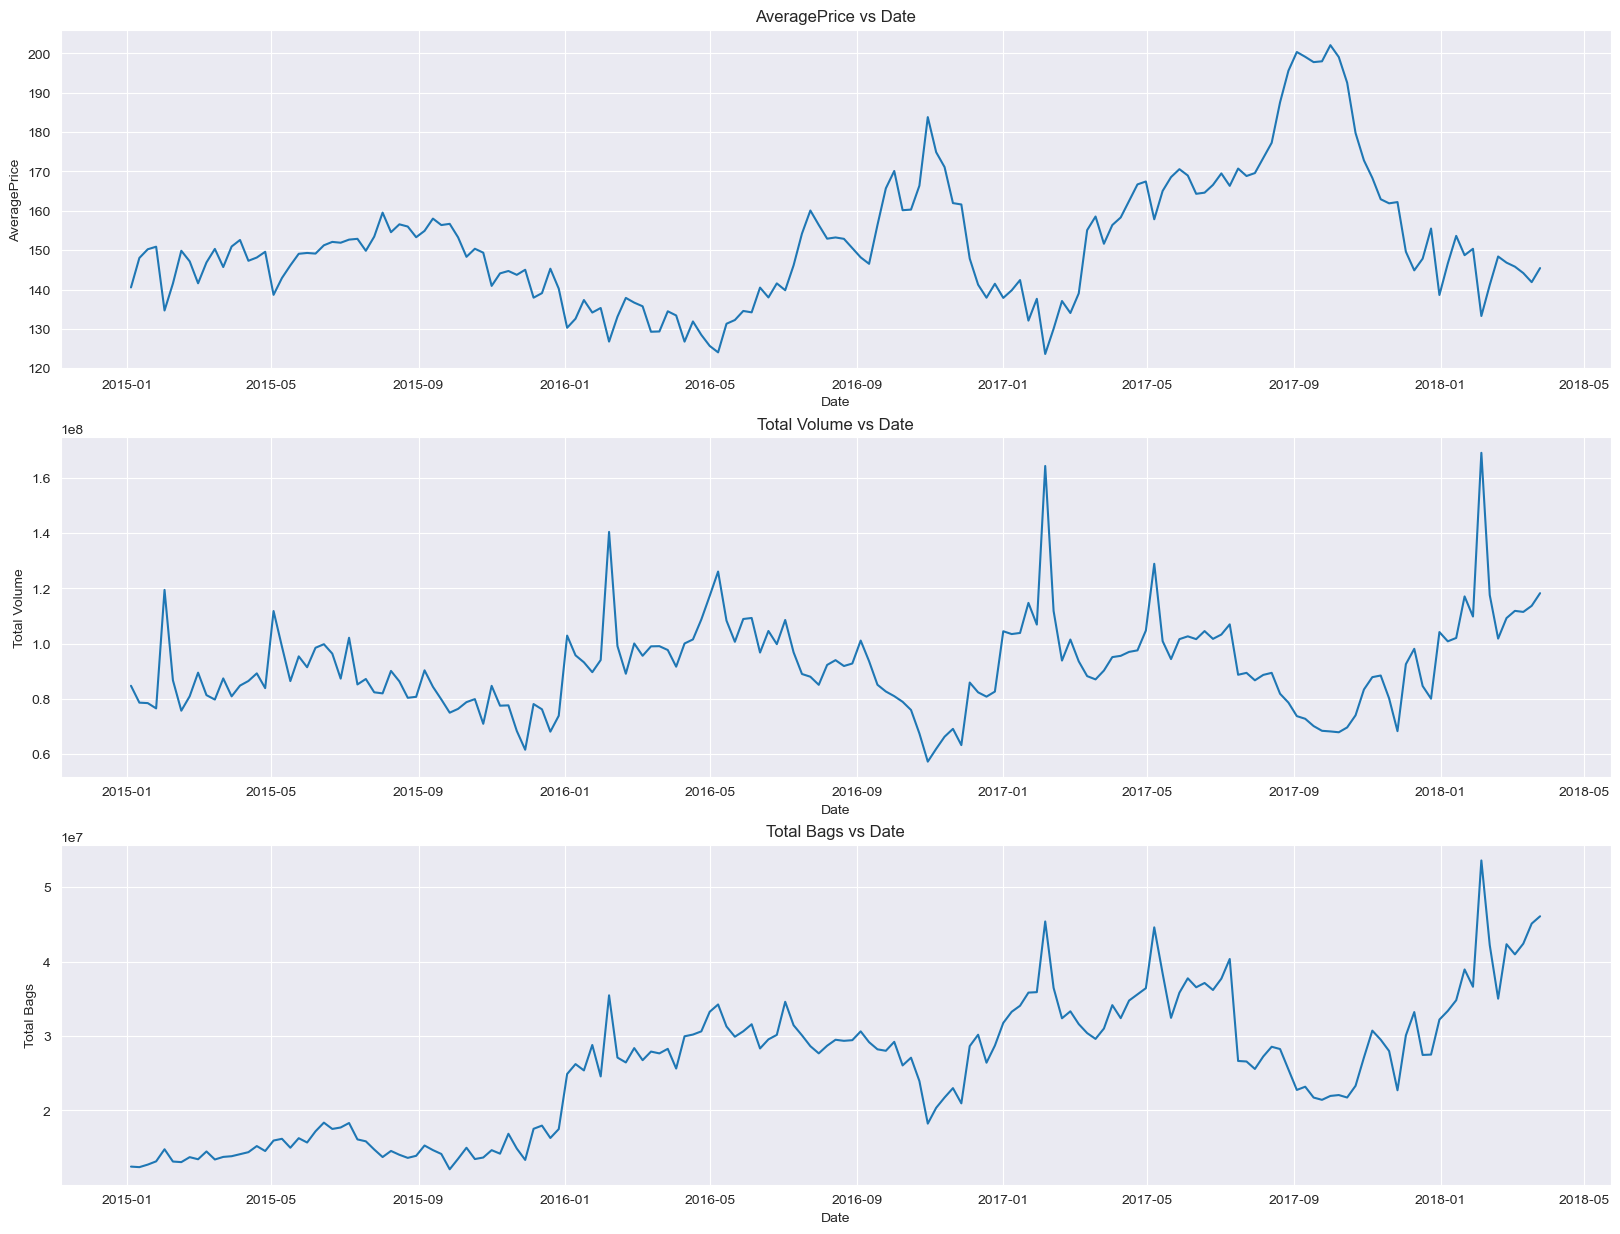

In [25]:
l1 = ['AveragePrice','Total Volume','Total Bags']
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (20,15))
for i in range(len(l1)):
    
    plt.subplot(3,1,i+1)
    sns.lineplot(x = df1.index,y = l1[i],data = df1)
    title = l1[i] + ' vs Date'
    plt.title(title);

- From the above graphs, we can say that **AveragePrice** vs **Total Volume** & **Total Bags** is negatively correlated or complement each other. 
- **AveragePrice** is inversely proportional to **Total Volume** & **Total Bags** whereas **Total Volume** displays a directly proportional relationship with **Total Bags**.
- Assuming the graphs are superimposed, the crests & troughs of **AveragePrice** would overlap the troughs & crests of **Total Volume** & **Total Bags** respectively.
- This relationship between **AveragePrice** vs **Total Volume** & **Total Bags** w.r.t **Date** can be associated with the **Law of Supply and Demand**.
    - If the supply increases and demand stays the same, the price will go down. 
    - If the supply decreases and demand stays the same, the price will go up. 
    
- **AveragePrice**, **Total Volume** and **Total Bags** displays an uptrend with **Date**.

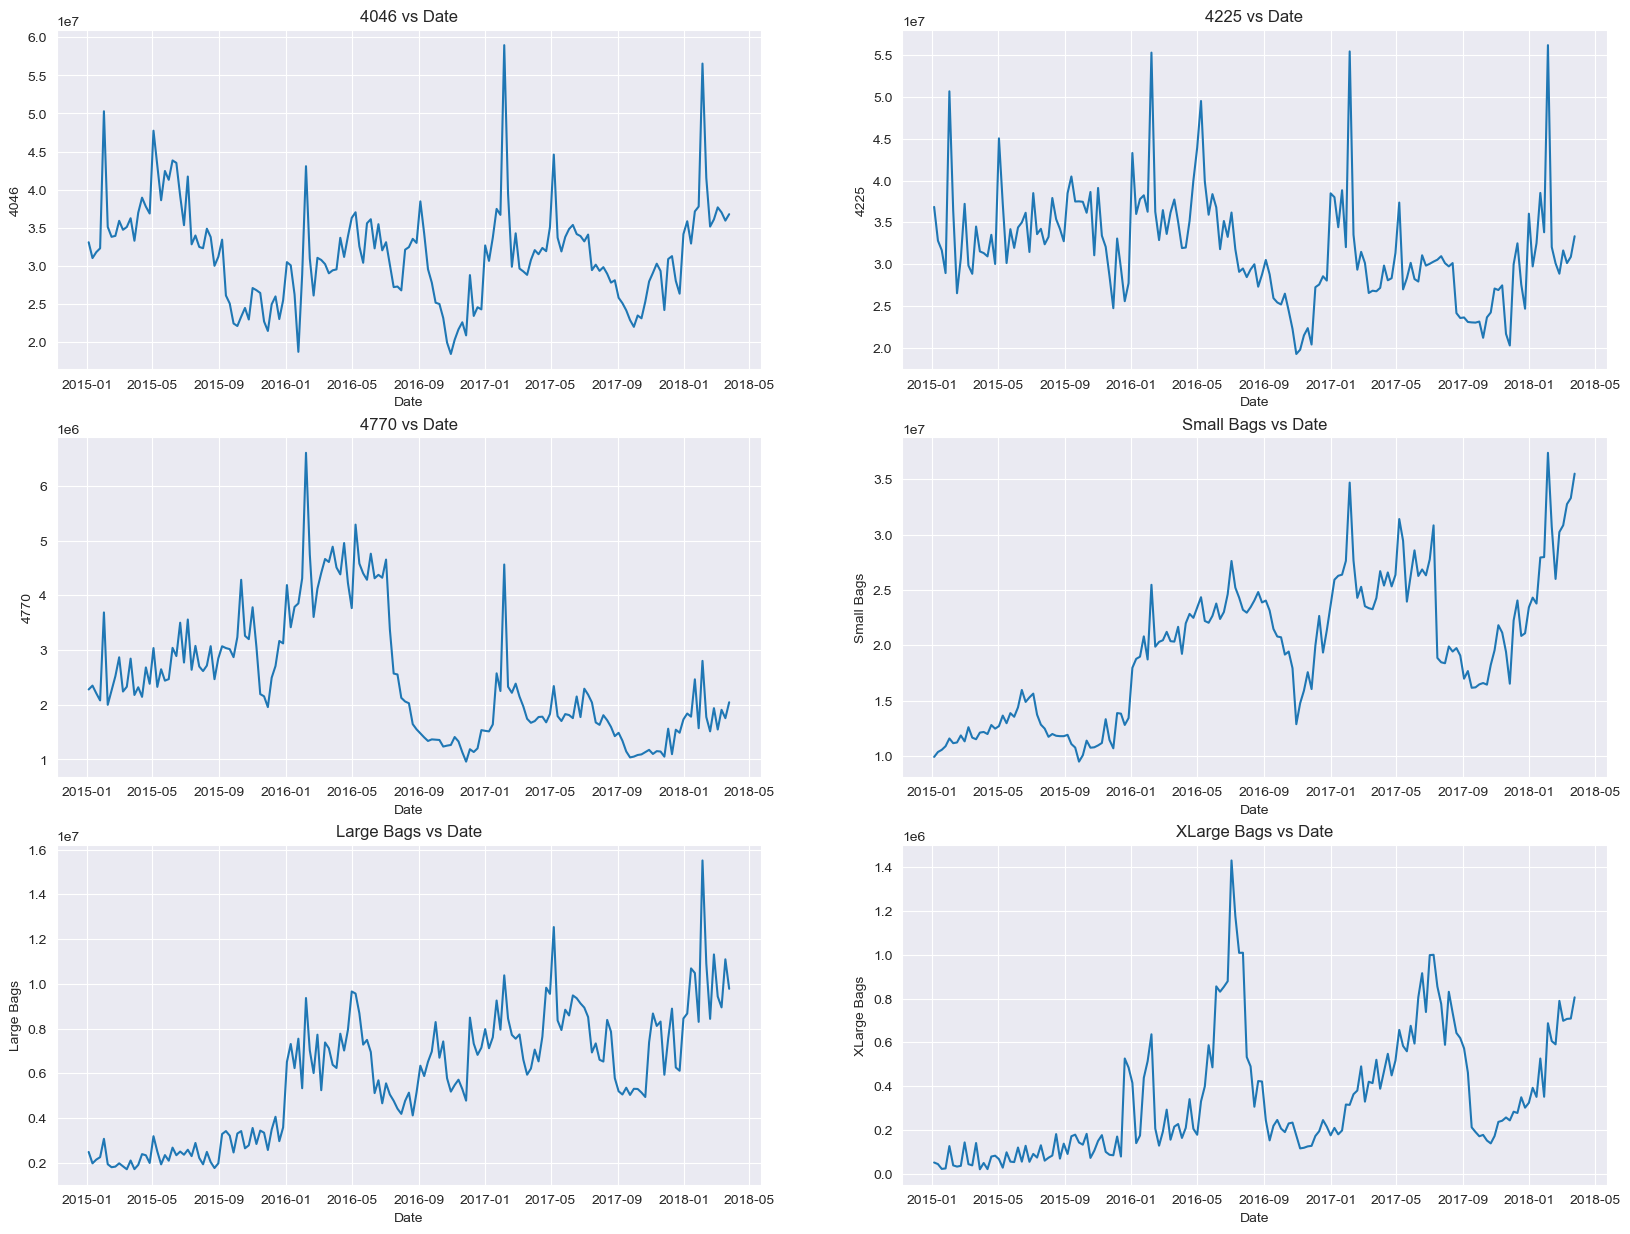

In [26]:
l2 = ['4046','4225','4770','Small Bags','Large Bags','XLarge Bags']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20,15))
for i in range(len(l2)):
    
    plt.subplot(3,2,i+1)
    sns.lineplot(x = df1.index,y = l2[i],data = df1)
    title = l2[i] + ' vs Date'
    plt.title(title);

- Avocados with PLU (Product Lookup Code) **4046** and **4225** kind of display the same patterns w.r.t **Date**. Crests and troughs are very similar to each other. 
- **4770** type of avocado has a seen a decrease in it's demand as time progresses. It has encountered a sharp drop in demand during the later months of 2016 and has not recovered since then.  
- Use of **bags** w.r.t avocados has definitely been on the up! All the **bags** display a rising graph w.r.t **Date**. From the values present on y-axis, customers prefer to use the **Small Bags**.

### Numerical Features vs region w.r.t Categorical Features :

- In this case, we will only visualize the **Total Volume** and **Total Bags** numerical features against **region** w.r.t **year** and **type**.

#### Total Volume vs region w.r.t year :

In [27]:
color2 = ['#DF3C22','#203EB9', '#F5EE04','#50CD27']

sns.catplot('Total Volume','region',data = data,hue = 'year',height = 8,palette = color2,kind = 'point');

TypeError: catplot() got multiple values for argument 'data'

- This graph is unable to provide significant insights about year on year difference in avocado **Total Volume** consumed in different cities due to overlapping of data points.
- **region** has mixed elements with the names of the cities and division of the country based on cardinal direction & non-cardinal directions like : **[Midsouth, Northeast, SouthCentral, Southeast, West, TotalUS]**.
- All the elements based on cardinal directions & non-cardinal directions display a huge spike in demand for avocado. This is probably because of the data collected for these elements is a combination of mulitple city data.
- **California**, **Great Lakes**, **Los Angeles** and **Plains** are some of the cities that highlight heavy consumption of avocado through **Total Volume**. 

#### Total Volume vs region w.r.t type :

In [ ]:
sns.catplot('Total Volume','region',data = data,hue = 'type',height = 8,palette = color1,kind = 'point');

- This graph is very similar to the graph above in terms of the positions of the spike. 
- Elements based on cardinal directions & non-cardinal directions display the same spikes with a clear cut preference towards **Conventional(0)** avocados that supports the information gained from other visualizations.
- Cities can like **DallasFtWorth**, **Denver**, **Houston**, **New York**, **PhoenixTucson** and **San Francisco** can be added to the previous of **California**, **Great Lakes**, **Los Angeles** and **Plains** that showcase their preference towards **Conventional(0)** avocado.

#### Total Bags vs region w.r.t year :

In [ ]:
sns.catplot('Total Bags','region',data = data,hue = 'year',height = 8,palette = color2,kind = 'point');

- Use of **bags** is highly correlated with **Total Volume**.
- From the data point **TotalUS** on the y-axis of the graph, we can say that there is crystal clear rise in use of bags.

#### Total Bags vs region w.r.t type :

In [ ]:
sns.catplot('Total Bags','region',data = data,hue = 'type',height = 8,palette = color1,kind = 'point');

- This graph is also very similar to the graphs above. No new information was gained.

# <center>Summary of EDA</center>

- **AveragePrice** of the avocados starts just below 1.2 and is found to be rising above 1.8 during the peak season. This rise in **AveragePrice** is due to the low **Total Volume** of avocados around the months of December / January and drop in **AveragePrice** is in the months September - November.
- When it comes down to the type of avocados, **Conventional(0)** dominates the **Organic(1)** type by a huge margin. **AveragePrice** of **Conventional(0)** type is just below 1.2 and for **Organic(1)** it is above 1.6.
- **Law of Supply & Demand** can be observed for **AveragePrice** of avocados vs **Total Volume** & **Total Bags**.
- A clear cut rising trend in the **Total Volume** of the avocados can be observed from 2015. Assuming the average purchase order of the avocados is quite high, customers prefer the **Conventional(0)** avocados due to its low **AveragePrice** compared to that of **Organic(1)**.
- For avocados based on PLU code **4046**, **4225**, **4770** following order of preference can be observed :
    - **2015** : **4046** ≅ **4225** ≅ **4770**
    - **2016** : **4770** > **4225** > **4046**
    - **2017** : **4046** > **4225** > **4770**
- For **bags**, **Law of Cause and Effect** can be observed with **Total Volume** of avocados. As the **Total Volume** of the avocados increased, usage of bags for avocados went up as well.

# <center>Time Series Analysis</center>

In [ ]:
df1 = data.copy(deep = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()

- We create a deep copy of the original dataset and resample the data in this new copy of dataset.
- Converting the datatype of the **Date** column to datetime and setting it as the index of the dataset.
- In this case, we resample the elements of the **Date** column weekly i.e the data gets arranged in the weekly format. Resampling according to week, reduces the dataset dataset size which was orginally in weekday format. 
- The aggregated function used in this case is **sum()**. Due to this if any data point falls in between the week, the values of that data point will be added up and it will be assigned to the 1st day of the week.

### Before Resampling :
        
|Date|AveragePrice|
|-|-|
|2015-01-04|100|
|2015-01-05|100|
|2015-01-06|100|
|2015-01-11|200|

### After Resampling :
        
|Date|AveragePrice|
|-|-|
|2015-01-04|300|
|2015-01-11|200|

In [ ]:
l3 = list(df1.columns)
l3.remove('AveragePrice')

df1.drop(columns = l3,inplace =True)
df1.head()

- This is a univariate time series analysis problem where we want to forecast a single time dependent variable, **AveragePrice**. Hence, we set **Date** as the dataframe index and drop the remaining columns.
- To avoid typing the names of all the columns to be dropped, a list is created with all the columns to be dropped from the columns method of the dataframe and **AveragePrice**, the feature we require, is dropped from the list.

### Supportive Functions for TIme Series Analysis :

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Components of Time Series :
- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
    E.g : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
    E.g : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
    E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
    E.g : Occurrences of Earthquakes or Floods, etc.
    
    
- **In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.** 

Let's visualize the **AveragePrice** data for the above components!
- For this purpose, we use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

From the visualizations of **AveragePrice** executed in EDA section, we can say that the data represents a **Multiplicative Model**.

In [ ]:
dec = sm.tsa.seasonal_decompose(df1['AveragePrice'], model = 'multiplicative').plot()
plt.show();

- Data clearly has a **non-linear uptrend**.
- A clear cut **seasonal** pattern is present in the data.
- The last plot is the **Residual** plot. It is the plot that describes the data if the **trend** and **seasonal** components of the data are completely eliminated.
- We also need to check the statistical parameters w.r.t time. 

### Stationarity :

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical paramters will change values over time as they are extracted from the features.
- If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
- Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.
- To test stationarity, we will use **Augmented Dickey Fuller Test** : 
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, then the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **#Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected and accepting that the time series is stationary, there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

In [ ]:
test_stationarity(df1['AveragePrice'])

- For the **AveragePrice** time series data, 
    - **Rolling Mean** is clearly variable with time. It is very close to the data. Thus, it can be a good descriptor of the data.
    - **Rolling Standard Deviation** is pretty consistent in the initial stages however changes with time are observed in the later stages.
    - **Test Statistic : (-2.36)** > **Critical Value (5%) : (-2.88)**
    - **p-value (0.15)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above **AveragePrice** time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value. 

In [ ]:
df1['Log_AveragePrice'] = np.log(df1['AveragePrice'])
df1_log_diff = df1['Log_AveragePrice'].diff()
df1_log_diff = df1_log_diff.dropna()

dec = sm.tsa.seasonal_decompose(df1_log_diff,period = 52).plot()
plt.show()

- We have taken the **log** of the data to deal with **stationarity** and **differencing** is done to handle **trend** and **seasonality**.
- **Trend** and **Seasonality** of the data have near about died down & their values have been reduced as well.
- We now check the **stationarity** of the time series.

In [ ]:
test_stationarity(df1_log_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0 but very small variations are present in it.
    - **Rolling Standard Deviation** is very close to 0.05 with some crests and troughs present throughout.
    - **Critical Value (5%) : (-2.88)** > **Test Statistic : (-13.82)**. We can say that the time series is **stationary with 99%** confidence as the **Test Statistic** is less than **Critical Value (1%)**.
    - **0.05** > **p-value (0.00)**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**.

# <center>Modeling</center>

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

- **ARIMA** model is a combination of 3 models :
    - **AR (p) : Auto Regressive**
    - **I (d) : Integrated**
    - **MA (q) : Moving Average**

- **(p,d,q)** is known as the order of the **ARIMA** model. Values of these parameters are based on the above mentioned models.  
    - **p** : Number of auto regressive terms. 
    - **d** : Number of differencing orders required to make the time series stationary.
    - **q** : Number of lagged forecast errors in the prediction equation.

- Selection criteria for the order of **ARIMA** model : 
    - **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
    - **d** : Number of times differencing is carried out to make the time series stationary.
    - **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

In [ ]:
tsplot(df1['AveragePrice'],lags = 10)

- **ACF** graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- **PACF** graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.
- From the **PACF** graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the **ACF** graph where the next lag follows it's previous lag.

In [ ]:
tsplot(df1_log_diff,lags = 10)

- From the above plots, the following order of **ARIMA** model is selected from the selection criteria mentioned above :
    - **p** : 1
    - **d** : 1
    - **q** : 2
- The data passed for model fitting is the **Log_AveragePrice** data that is non-differenced data and non-stationary data.
- In order to make the series stationary, we difference the time series. Thus, this differencing of data is carried out by the ARIMA model with the help of the **d** parameter that provides info about the order of differencing.
- Thus, the parameters **p** and **q** are selected in such a way that we pass their values assuming the ARIMA model carries out the differencing process and makes the time series stationary.

In [ ]:
model = ARIMA(df1['Log_AveragePrice'],order = (1,1,2))
model_fit = model.fit()
print(model_fit.summary())

- Model fitting is a measure of how well a machine learning model generalizes to similar data to that on which it was trained.
- After fitting the ARIMA model, we now check this fit and compare this series with the original values of **AveragePrice**.
- In this process, we store the model fitted values in a series. This series then undergoes the process of cummulative summation i.e opposite of differencing.
- Result of cummulative summation is the expected log values fitted by the model. These log values are then exponentiated that creates the fitted original series.

In [ ]:
# Fitted values of the model
predictions_ARIMA = pd.Series(model_fit.fittedvalues, copy=True)

# Reversing the 1st order Differencing by taking cumulative sum 
predictions_ARIMA_cumsum = predictions_ARIMA.cumsum()

# Creating a series with the same length as the original 'Log_AveragePrice'
# All the elements of this new series are same as the 1st element of the original 'Log_AveragePrice'
expected_log_values = pd.Series(df1['Log_AveragePrice'].iloc[0], index = df1['Log_AveragePrice'].index)

# Adding the elements of this newly created series with the cumulative sum series
expected_log_values = expected_log_values.add(predictions_ARIMA_cumsum,fill_value = 0)

# Taking log of the above series for getting the original values 
predictions_ARIMA_final = np.exp(expected_log_values)

fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['AveragePrice'],label = 'AveragePrice')
plt.plot(predictions_ARIMA_final,label = 'Fitted AveragePrice');
plt.legend(loc="upper left")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_final - df1['AveragePrice'])**2)/len(df1['AveragePrice'])));

- RMSE value between **Fitted AveragePrice** and original **AveragePrice** is **21.83**.
- This RMSE is slightly high and does creates the possibility of overfitting the model.

### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [ ]:
size = int(len(df1) - 30)
train, test = df1['Log_AveragePrice'][0:size], df1['Log_AveragePrice'][size:len(df1)]

print('\t ARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (np.exp(yhat), np.exp(obs)))

In [ ]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['AveragePrice'],label = 'Expected Values')
plt.plot(np.exp(predictions_series),label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- **Predicted Values** and **Expected Values** are very close by and kind of display an overfit model.

In [ ]:
error = np.sqrt(mean_squared_error(np.exp(test),np.exp(predictions)))
print('Test RMSE: %.4f' % error)
predictions_series = pd.Series(np.exp(predictions), index = test.index)

- Test RMSE value is quite better than the fitted RMSE value.
- Use of weekly data and presence of seasonality can also have an effect on the model performance. We will move on to **Out - Of - Sample Forecasting**.

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **non-rolling** forecast method by using **forecast function** and **predict function**. 
- In the **non-rolling** method, we forecast or predict all future values at once.

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates = [df1.index[-1] + DateOffset(weeks = x) for x in range(0,52)]

# New dataframe for storing the future values
df2 = pd.DataFrame(index = future_dates[1:],columns = df1.columns)

forecast = pd.concat([df1,df2])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

- We create 2 new columns for storing the values forecasted or predicted into **ARIMA_Forecast_Function** and **ARIMA_Predict_Function**.

#### Forecast Function : 

In [ ]:
f1 = np.array(np.exp(model_fit.forecast(steps = 51)[0]))

for i in range(len(f1)):
    forecast.iloc[169 + i,2] = f1[i]
forecast.tail()

- We use the **np.exp()** as we fit the model on log values and hence we unlog the values using exponentiation function.

In [ ]:
forecast[['AveragePrice','ARIMA_Forecast_Function']].plot(figsize = (12,8));

- Values generated by the **forecast_function** are constant.

#### Predict Function :

In [ ]:
f2 = np.array(np.exp(model_fit.predict(start = 169,end = 219,typ = 'levels')))

for i in range(51):
    forecast.iloc[169 + i,3] = f2[i]
forecast.tail()

In [ ]:
forecast[['AveragePrice','ARIMA_Predict_Function']].plot(figsize = (12,8));

- Similar pattern can be observed for the values generated by the **predict_function**. 
- Let's compare the values generated by the **forecast_function** and **predict_function**.

In [ ]:
sum(f1) == sum(f2)

- For the above trained ARIMA model, values generated by **forecast_function** and **predict function** are either exactly identical or just differ by a few decimal points!
- The model clearly did not capture the **seasonal patterns** of the data.

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**. 
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model. 
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model. 
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M**. 

In [ ]:
df1_log_diff_seas = df1_log_diff.diff(52)
df1_log_diff_seas = df1_log_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(df1_log_diff_seas).plot()
plt.show()

- For our data, it is in **weekly format** and the **seasonal period is of 1 year**.
- Hence, we difference the already differenced data by a periodicity, **M**, value of 52.
- We can observe that the seasonality of the data nearabout gone with y-axis values ranging from -0.1 to 0.1.
- We will check this seasonal differenced data for stationarity.

In [ ]:
test_stationarity(df1_log_diff_seas)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0 but very small variations are present in it.
    - **Rolling Standard Deviation** is very close to 0.05 with some crests and troughs present throughout.
    - **Critical Value (5%) : (-2.89)** > **Test Statistic : (-4.60)**. We can say that the time series is **stationary with 99%** confidence as the **Test Statistic** is less than **Critical Value (1%)** as well.
    - **0.05** > **p-value (0.00)**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**.

In [ ]:
tsplot(df1_log_diff_seas)

- For the **SARIMA** model, order of **(p,d,q)** will be same as the order of the **ARIMA** model above. 
- For **(P,D,Q,M)** :
    - **P** : 0
    - **D** : 1
    - **Q** : 0
    - **M** : 52
- For **SARIMA**, creating a grid search framework and selecting the parameters with the lowest **AIC** & **BIC** values is also a popular choice.

In [ ]:
model = sm.tsa.statespace.SARIMAX(df1['Log_AveragePrice'],order = (1,1,2),seasonal_order = (0,1,0,52))
model_fit = model.fit()
print(model_fit.summary())

### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset similar to the approach of **ARIMA** model.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [ ]:
size = int(len(df1) - 30)
train, test = df1['Log_AveragePrice'][0:size], df1['Log_AveragePrice'][size:len(df1)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (1,1,2),seasonal_order = (0,1,0,52))
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (np.exp(yhat), np.exp(obs)))

In [ ]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['AveragePrice'],label = 'Expected Values')
plt.plot(np.exp(predictions_series),label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- **Predicted Values** and **Expected Values** are very close by and kind of display an overfit model.

In [ ]:
error = np.sqrt(mean_squared_error(np.exp(test),np.exp(predictions)))
print('Test RMSE: %.4f' % error)
predictions_series = pd.Series(np.exp(predictions), index = test.index)

- Test RMSE value is ok.
- We will move on to **Out - Of - Sample Forecasting**.

### Out of Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- For this **Out - of - Sample Forecasting**, we use the **non-rolling** forecast method by using **forecast function** and **predict function**. 
- In the **non-rolling** method, we forecast or predict all future values at once. We store these future values into 2 new columns **SARIMA_Forecast_Function** and **SARIMA_Predict_Function** in the existing **forecast** dataframe.

In [ ]:
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

#### Forecast Function : 

In [ ]:
f3 = np.array(np.exp(model_fit.forecast(steps = 51)))

for i in range(len(f3)):
    forecast.iloc[169 + i,4] = f3[i]
forecast.tail()

In [ ]:
forecast[['AveragePrice','SARIMA_Forecast_Function']].plot(figsize = (12,8));

- From the above graph, we can say that the **SARIMA** model was able to capture the seasonal patterns and created a slight uptrend future predictions.

#### Predict Function :

In [ ]:
f4 = np.array(np.exp(model_fit.predict(start = 169,end = 219,typ = 'levels')))

for i in range(51):
    forecast.iloc[169 + i,5] = f4[i]
forecast.tail()

In [ ]:
forecast[['AveragePrice','SARIMA_Predict_Function']].plot(figsize = (12,8));

- The graph is very similar to the graph above, we will check the values of **SARIMA_Forecast_Function** and **SARIMA_Predict_Function**.

In [ ]:
sum(f3) == sum(f4)

- For the above trained **SARIMA** model, values generated by **forecast_function** and **predict function** are either exactly identical or just differ by a few decimal points!
- This model captured the **seasonal patterns** of the data much better!

# <center>Conclusion</center>

- This is a good dataset for understanding **Time Series Analysis** problems. It opens up the opportunity to learn multiple concepts and dealing with weekly data. 


- EDA section provides some great insights that can be associated with the business problems for selling of avocados. 


- For the **Time Series Analysis** section, stationarity, understanding the kind of data the models train on, different transforms that are carried out, etc can be a tricky and abit overwhelming as well. This is because it has too many things that need to be dealt with.  


- Difference between **ARIMA** and **SARIMA** model can also be clearly understood. Similarly, usage of **forecast_function** & **predict_function** for **In - Sample Forecasting** & **Out - of - Sample Forecasting** using **rolling** and **non - rolling** method can be understood.  

## Other Work :

#### [Off topic Notebooks](https://www.kaggle.com/tanmay111999/code)
- Recently, 3 new notebooks on the topic **Binary Classification** can be found :
    - [Heart Disease Prediction](https://www.kaggle.com/code/tanmay111999/approach-for-binary-classification-heart-failure)
    - [Heart Failure Prediction](https://www.kaggle.com/code/tanmay111999/beginner-friendly-extensive-eda-modeling)
    - [Credit Card Fraud Detection : Imbalanced Dataset](https://www.kaggle.com/code/tanmay111999/smote-for-imbalanced-data-beginner-friendly)
- Other Notebooks include work on [Image Classification using pretrained models](https://www.kaggle.com/code/tanmay111999/basic-image-classification-vgg16-ml-algorithms).

# <center>Please upvote if you like the work!</center>
# <center>Any sort of feedback would be appreciated!</center>
# <center>Thank You!</center>